# HW#02: Deep Operator Networks Assignment
## CE397 and CSE393: Scientific Machine Learning
#### Qianqian Tong, qt737

## 1 Learning the Derivative Operator

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

print(f'PyTorch version: {torch.__version__}')
print(f'CUDA available: {torch.cuda.is_available()}')

PyTorch version: 2.6.0
CUDA available: False


In [2]:
# a) Define DeepONet Architecture

class BranchNet(nn.Module):
    def __init__(self, input_dim=100, hidden_dim=32, output_dim=50):
        super(BranchNet, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, u_sensors):
        return self.network(u_sensors)


class TrunkNet(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=32, output_dim=50):
        super(TrunkNet, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, y):
        return self.network(y)


class DeepONet(nn.Module):
    def __init__(self, sensor_dim=100, hidden_dim=32, basis_dim=50):
        super(DeepONet, self).__init__()
        self.branch = BranchNet(sensor_dim, hidden_dim, basis_dim)
        self.trunk = TrunkNet(1, hidden_dim, basis_dim)
        self.bias = nn.Parameter(torch.zeros(1))
    
    def forward(self, u_sensors, y_query):
        b = self.branch(u_sensors)
        t = self.trunk(y_query)
        if t.dim() == 2:
            b = b.unsqueeze(-1)
            t = t.T.unsqueeze(0)
            output = torch.bmm(b.transpose(1, 2), t.expand(b.size(0), -1, -1))
            output = output.squeeze(1)
        else:
            output = torch.sum(b.unsqueeze(1) * t, dim=-1)
        output = output + self.bias
        return output

print("DeepONet architecture defined.")

DeepONet architecture defined.


In [3]:
# b) Define Dataset

class DerivativeDataset(Dataset):
    def __init__(self, N=2000, m=100, P=100, x_range=(-1, 1)):
        self.N, self.m, self.P = N, m, P
        self.x_sensors = np.linspace(x_range[0], x_range[1], m)
        self.y_query = np.linspace(x_range[0], x_range[1], P)
        self.A = np.random.uniform(0.5, 2.0, N)
        self.omega = np.random.uniform(1, 5, N)
        self.phi = np.random.uniform(0, 2*np.pi, N)
        self.u_sensors = np.zeros((N, m))
        self.du_query = np.zeros((N, P))
        for i in range(N):
            self.u_sensors[i] = self.A[i]*np.sin(self.omega[i]*self.x_sensors + self.phi[i])
            self.du_query[i] = self.A[i]*self.omega[i]*np.cos(self.omega[i]*self.y_query + self.phi[i])
    
    def __len__(self): return self.N
    def __getitem__(self, idx):
        return (torch.FloatTensor(self.u_sensors[idx]),
                torch.FloatTensor(self.y_query).unsqueeze(1),
                torch.FloatTensor(self.du_query[idx]))

print("Dataset class defined.")

Dataset class defined.


In [4]:
# c) Define Training and Functions

def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    for u_sensors, y_query, du_true in dataloader:
        u_sensors, y_query, du_true = u_sensors.to(device), y_query[0].to(device), du_true.to(device)
        du_pred = model(u_sensors, y_query)
        loss = torch.mean((du_pred - du_true) ** 2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def validate(model, dataloader, device):
    model.eval(); total_loss = 0
    with torch.no_grad():
        for u_sensors, y_query, du_true in dataloader:
            u_sensors, y_query, du_true = u_sensors.to(device), y_query[0].to(device), du_true.to(device)
            du_pred = model(u_sensors, y_query)
            total_loss += torch.mean((du_pred - du_true) ** 2).item()
    return total_loss / len(dataloader)

def train_model(model, train_loader, val_loader, optimizer, scheduler, device, max_epochs=500, patience=100):
    best_val_loss = float('inf'); patience_counter = 0
    train_losses, val_losses = [], []
    for epoch in range(max_epochs):
        train_loss = train_epoch(model, train_loader, optimizer, device)
        val_loss = validate(model, val_loader, device)
        train_losses.append(train_loss); val_losses.append(val_loss)
        scheduler.step(val_loss)
        if val_loss < best_val_loss:
            best_val_loss, patience_counter, best_state = val_loss, 0, model.state_dict().copy()
        else: patience_counter += 1
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}: Train {train_loss:.6f}, Val {val_loss:.6f}, LR {optimizer.param_groups[0]["lr"]:.6f}')
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}"); break
    model.load_state_dict(best_state)
    return train_losses, val_losses

print("Training functions defined.")

Training functions defined.


In [5]:
# a-b
torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

full_dataset = DerivativeDataset(N=2000, m=100, P=100)
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
print(f'Train size: {train_size}, Val size: {val_size}, Test size: {test_size}')

model = DeepONet(sensor_dim=100, hidden_dim=32, basis_dim=50).to(device)
print(f'Model parameters: {sum(p.numel() for p in model.parameters())}')

Train size: 1600, Val size: 200, Test size: 200
Model parameters: 8709


/opt/anaconda3/envs/qian/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Starting training...
Epoch 10: Train 0.552014, Val 0.420911, LR 0.010000
Epoch 20: Train 0.158364, Val 0.152578, LR 0.010000
Epoch 30: Train 0.080804, Val 0.072823, LR 0.010000
Epoch 40: Train 0.109989, Val 0.081803, LR 0.010000
Epoch 50: Train 0.047766, Val 0.037208, LR 0.010000
Epoch 60: Train 0.050895, Val 0.060529, LR 0.010000
Epoch 70: Train 0.054305, Val 0.049699, LR 0.010000
Epoch 80: Train 0.026243, Val 0.022023, LR 0.010000
Epoch 90: Train 0.074619, Val 0.082613, LR 0.010000
Epoch 100: Train 0.127130, Val 0.060119, LR 0.010000
Epoch 110: Train 0.022583, Val 0.028737, LR 0.010000
Epoch 120: Train 0.030119, Val 0.035240, LR 0.010000
Epoch 130: Train 0.027041, Val 0.030680, LR 0.010000
Epoch 140: Train 0.024665, Val 0.020120, LR 0.010000
Epoch 150: Train 0.024011, Val 0.027163, LR 0.010000
Epoch 160: Train 0.026482, Val 0.017777, LR 0.010000
Epoch 170: Train 0.019730, Val 0.019906, LR 0.010000
Epoch 180: Train 0.031477, Val 0.050454, LR 0.010000
Epoch 190: Train 0.048741, Val 0.

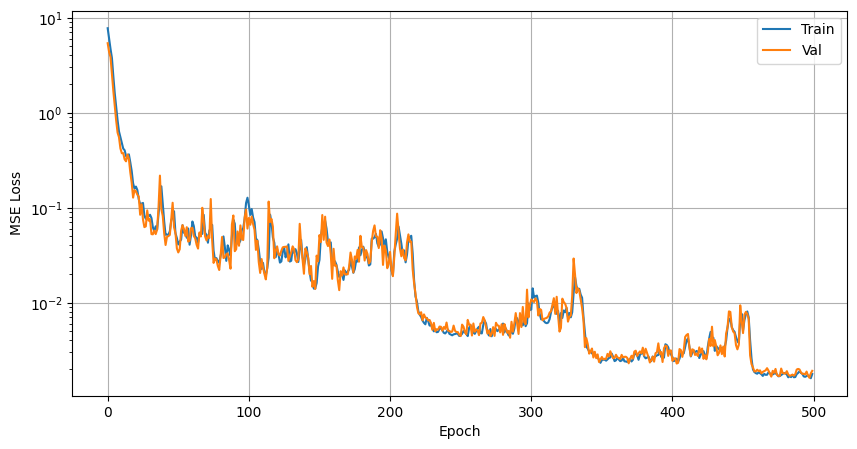

In [6]:
# d) Train Model

optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50, verbose=True)

print('\nStarting training...')
train_losses, val_losses = train_model(model, train_loader, val_loader, optimizer, scheduler, device)
test_loss = validate(model, test_loader, device)
print(f'\nTest Loss: {test_loss:.6f}')

plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss') 
plt.legend()
plt.grid(True)
plt.show()

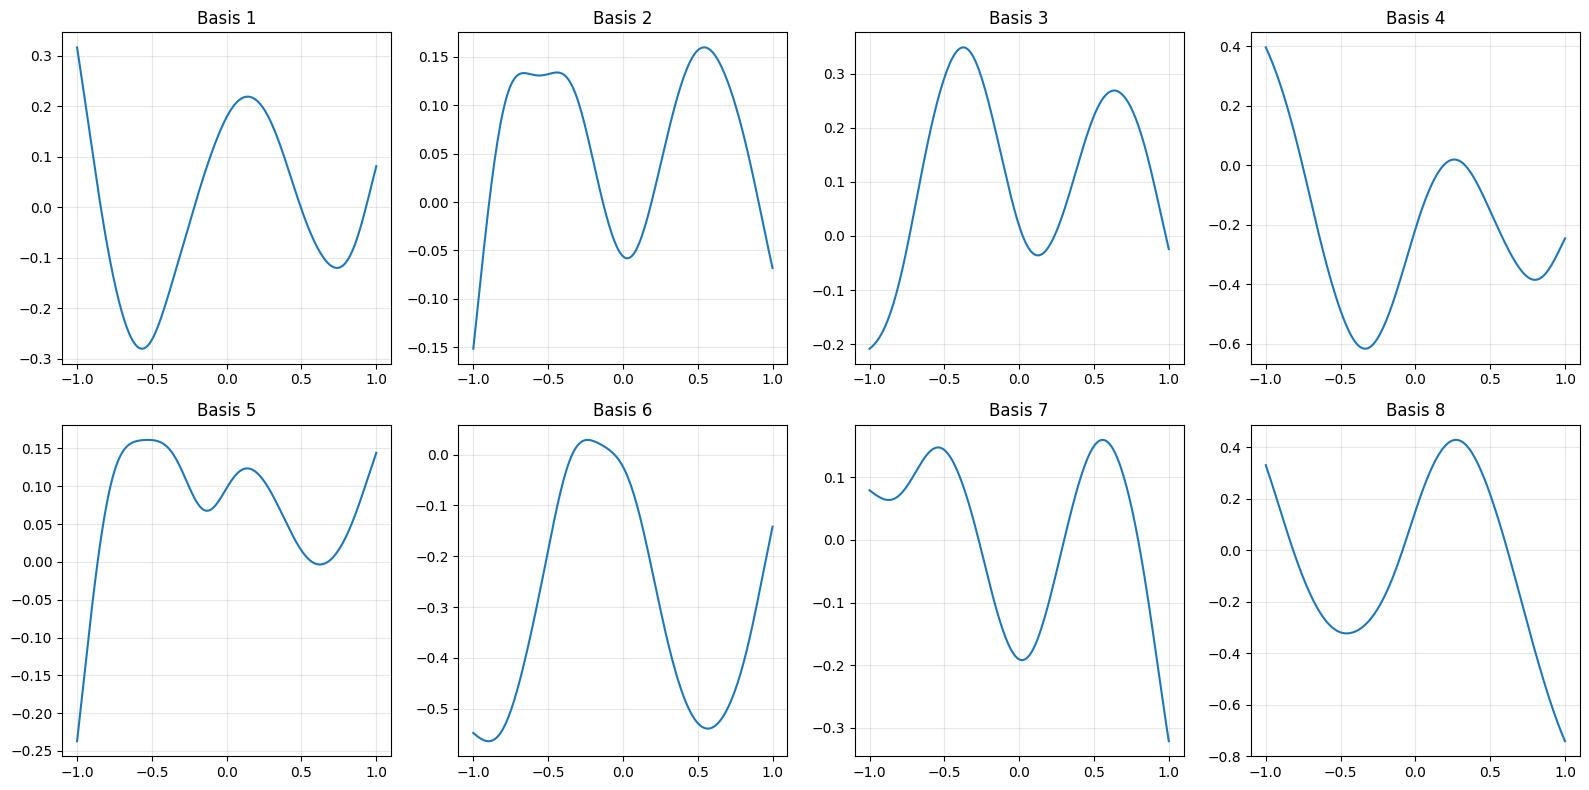

array([[ 3.1657401e-01, -1.5147975e-01, -2.0825569e-01, ...,
        -3.0771714e-01,  5.9106243e-01,  4.4317171e-02],
       [ 2.9701048e-01, -1.3669258e-01, -2.0605938e-01, ...,
        -2.9976827e-01,  5.8802152e-01,  5.0525729e-02],
       [ 2.7715534e-01, -1.2184568e-01, -2.0353423e-01, ...,
        -2.9174805e-01,  5.8475220e-01,  5.6573655e-02],
       ...,
       [ 5.7775103e-02, -5.3909615e-02, -2.7776134e-04, ...,
        -5.7966575e-02, -3.0065033e-01,  1.3345587e-01],
       [ 6.9673926e-02, -6.1077975e-02, -1.2359131e-02, ...,
        -7.0877843e-02, -3.2077396e-01,  1.4125559e-01],
       [ 8.1434466e-02, -6.8124130e-02, -2.4207709e-02, ...,
        -8.3659999e-02, -3.4034979e-01,  1.4887303e-01]], dtype=float32)

In [7]:
# e) Analyze the learned basis functions
def basis_functions(model, device, x_range=(-1,1), num_points=200):
    model.eval()
    y = torch.linspace(*x_range, num_points).unsqueeze(1).to(device)
    with torch.no_grad(): basis = model.trunk(y).cpu().numpy()
    y_np = y.cpu().numpy().squeeze()
    fig, axes = plt.subplots(2,4,figsize=(16,8)); axes = axes.flatten()
    for i in range(8):
        axes[i].plot(y_np, basis[:,i]); axes[i].set_title(f'Basis {i+1}')
        axes[i].grid(True, alpha=0.3)
    plt.tight_layout(); plt.show(); return basis

basis_functions(model, device)

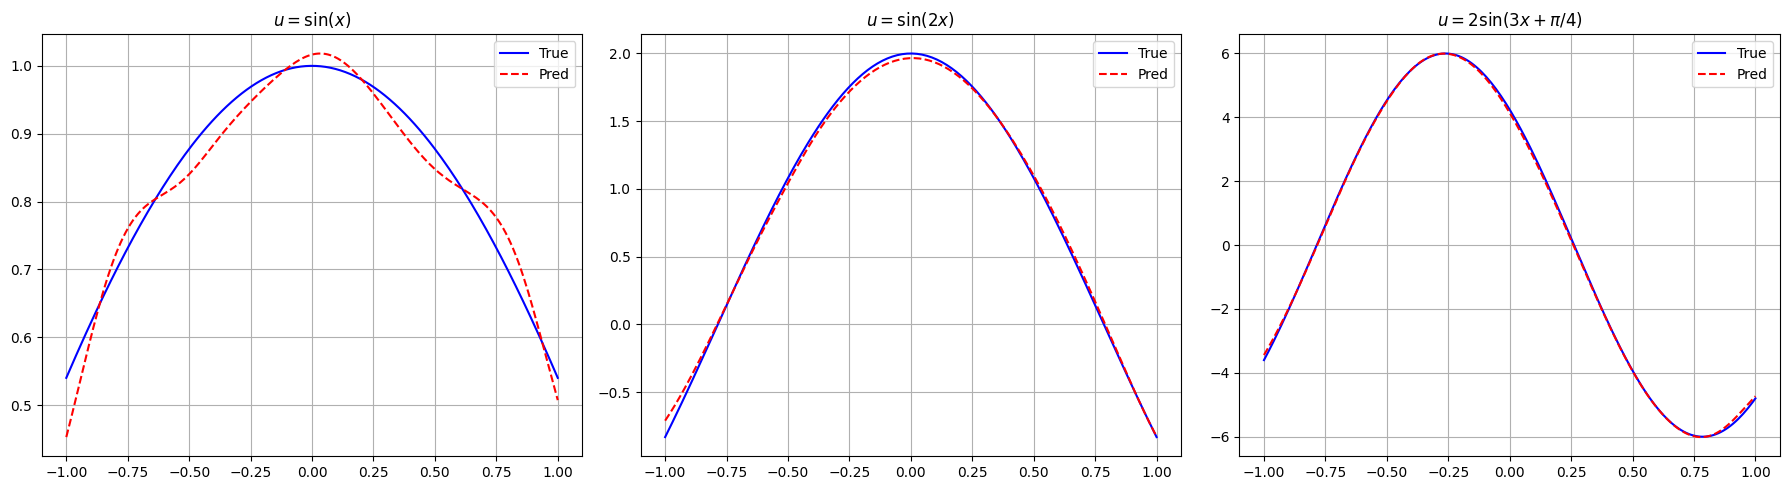

In [8]:
def test_cases(model, device, x_range=(-1,1), m=100, P=200):
    model.eval()
    cases = [(1,1,0,r'$u=\sin(x)$'), (1,2,0,r'$u=\sin(2x)$'), (2,3,np.pi/4,r'$u=2\sin(3x+\pi/4)$')]
    x_sensors = np.linspace(*x_range, m); y_query = np.linspace(*x_range, P)
    fig, axes = plt.subplots(1,3,figsize=(18,5))
    for idx, (A, ω, φ, label) in enumerate(cases):
        u = A*np.sin(ω*x_sensors+φ); du = A*ω*np.cos(ω*y_query+φ)
        u_t = torch.FloatTensor(u).unsqueeze(0).to(device); y_t = torch.FloatTensor(y_query).unsqueeze(1).to(device)
        with torch.no_grad(): du_pred = model(u_t, y_t).cpu().numpy().squeeze()
        axes[idx].plot(y_query, du, 'b-', label='True'); axes[idx].plot(y_query, du_pred, 'r--', label='Pred')
        axes[idx].set_title(label); axes[idx].legend(); axes[idx].grid(True)
    plt.tight_layout(); plt.show()

test_cases(model, device)

Explain how the branch network encodes frequency and amplitude information:

The branch network encodes different relationships learned from the input function $u(x)$.  

It captures a linear relationship with amplitude $A$, since the derivative operator $ \frac{du}{dx} = A\omega\cos(\omega x + \phi) $ scales proportionally with $A$, and a nonlinear relationship with frequency $\omega$, since $\omega$ affects both the magnitude and oscillatory pattern of the derivative.  

These learned features are represented as a latent vector $b(u) = [b_1, b_2, ..., b_p]$, where each component reflects different feature's impact. For each batch of input functions, the network produces a set of such vectors.  

Meanwhile, the trunk network outputs another vector $t(y) = [t_1, t_2, ..., t_p]$, which represents the spatial basis functions by query points $y$.  

where the branch network provides the encoded functional features and the trunk network provides the spatial info, together reconstructing the operator’s mapping from $u(x)$ to $G(u)(y)$.

In [9]:
# f) Evaluate Generalization

def evaluate_generalization(model, test_loader, device):
    model.eval()
    relative_errors = []

    with torch.no_grad():
        for u_sensors, y_query, du_true in test_loader:
            u_sensors, y_query, du_true = (
                u_sensors.to(device),
                y_query[0].to(device),
                du_true.to(device),
            )
            du_pred = model(u_sensors, y_query)
            for i in range(du_pred.shape[0]):
                pred = du_pred[i].cpu().numpy()
                true = du_true[i].cpu().numpy()
                rel_err = np.linalg.norm(pred - true) / np.linalg.norm(true)
                relative_errors.append(rel_err)

    relative_errors = np.array(relative_errors)

    print(f'Mean relative L² error: {np.mean(relative_errors):.6f}')
    print(f'Std relative L² error: {np.std(relative_errors):.6f}')
    print(f'Median relative L² error: {np.median(relative_errors):.6f}')
    return relative_errors

errors = evaluate_generalization(model, test_loader, device)

Mean relative L² error: 0.019723
Std relative L² error: 0.012907
Median relative L² error: 0.015982


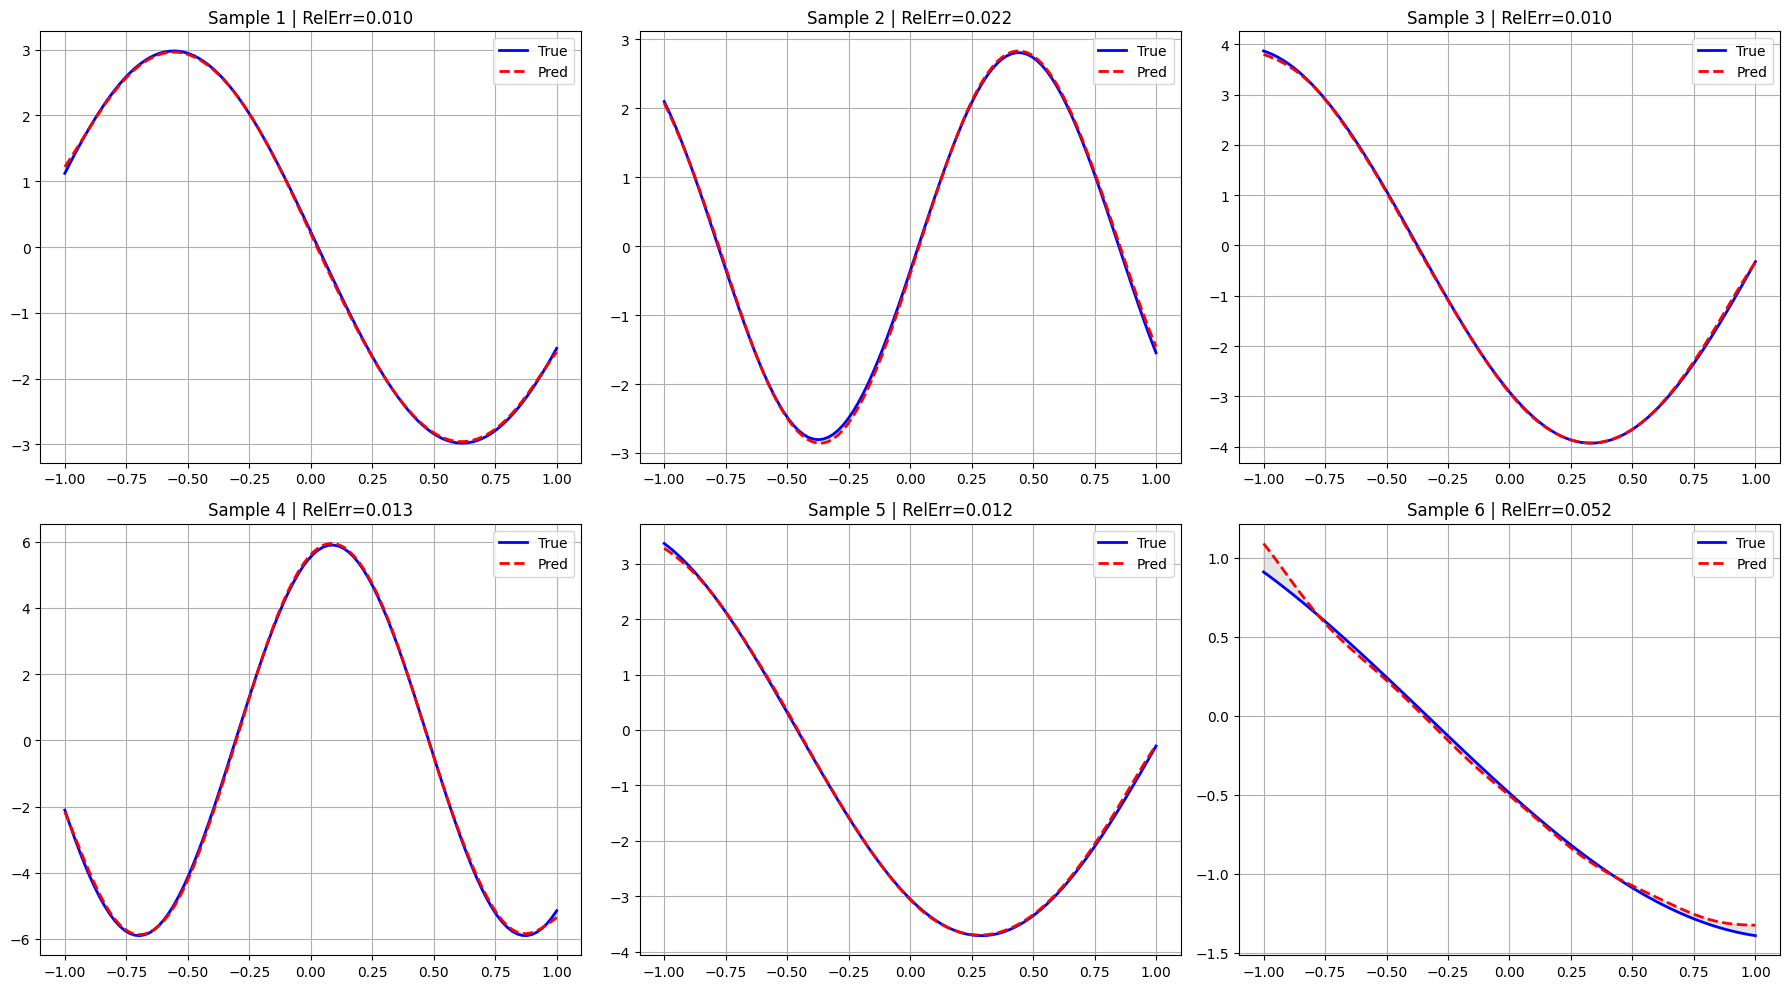

In [10]:
# f) Plot Predictions vs. True Predictions

def plot_sample_predictions(model, test_dataset, device, num_samples=6):
    model.eval()
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    indices = np.random.choice(len(test_dataset), num_samples, replace=False)

    with torch.no_grad():
        for i, idx in enumerate(indices):
            u_sensors, y_query, du_true = test_dataset[idx]
            u_sensors = u_sensors.unsqueeze(0).to(device)
            y_query = y_query.to(device)
            du_pred = model(u_sensors, y_query).cpu().numpy().squeeze()
            du_true = du_true.numpy()
            y = y_query.cpu().numpy().squeeze()

            mse = np.mean((du_pred - du_true)**2)
            rel_error = np.linalg.norm(du_pred - du_true) / np.linalg.norm(du_true)

            axes[i].plot(y, du_true, 'b-', label='True', linewidth=2)
            axes[i].plot(y, du_pred, 'r--', label='Pred', linewidth=2)
            axes[i].fill_between(y, du_true, du_pred, color='gray', alpha=0.2)
            axes[i].set_title(f'Sample {i+1} | RelErr={rel_error:.3f}')
            axes[i].legend()
            axes[i].grid(True)

    plt.tight_layout()
    plt.show()

plot_sample_predictions(model, test_dataset, device)

## 2. 1D Advection-Diffusion Equation

In [11]:
import numpy as np

In [12]:
nu = 0.01      # diffusion coefficient
c = 1.0        # advection velocity
nx = 100       # number of grid points
N = 1000       # number of source functions
x = np.linspace(0, 1, nx)
dx = x[1] - x[0]

# === Generate Fourier-based source functions f(x) ===
f_data = np.zeros((N, nx))
u_data = np.zeros_like(f_data)

for i in range(N):
    # Random coefficients c_n ~ N(0, (1/n)^2)
    coeffs = np.array([np.random.normal(0, 1/(n**2)) for n in range(1, 5)])
    f = sum(coeffs[n-1] * np.sin(n * np.pi * x) for n in range(1, 5))
    f_data[i, :] = f
    
    # Assemble tridiagonal system for steady advection-diffusion
    A = np.zeros((nx, nx))
    b = f.copy()

    # Dirichlet BCs: u(0)=u(1)=0
    A[0, 0] = 1.0
    A[-1, -1] = 1.0
    b[0] = 0.0
    b[-1] = 0.0

    # Fill interior using upwind for advection (since c>0)
    for j in range(1, nx-1):
        A[j, j-1] = nu/dx**2 + c/dx
        A[j, j]   = -2*nu/dx**2 - c/dx
        A[j, j+1] = nu/dx**2

    # Solve linear system A u = f
    u = np.linalg.solve(A, b)
    u_data[i, :] = u

In [13]:
import torch
import torch.nn as nn

In [14]:
# === Branch and Trunk Networks ===
class BranchNet(nn.Module):
    def __init__(self, input_dim=nx, hidden_dim=128, output_dim=100):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, f_in):
        return self.layers(f_in)


class TrunkNet(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=128, output_dim=100):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, y):
        return self.layers(y)

In [15]:
class DeepONet(nn.Module):
    def __init__(self):
        super().__init__()
        self.branch = BranchNet(nx, 128, 100)
        self.trunk  = TrunkNet(1, 128, 100)
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, f_in, y):
        b = self.branch(f_in)
        t = self.trunk(y)
        # Compute inner product between branch and trunk outputs
        return torch.sum(b.unsqueeze(1) * t, dim=-1) + self.bias

In [16]:
u_mean = np.mean(u_data)
u_std = np.std(u_data)
u_norm = (u_data - u_mean) / u_std

In [17]:
from torch.utils.data import Dataset, DataLoader

class AdvectionDataset(Dataset):
    def __init__(self, f, u):
        self.f = torch.tensor(f, dtype=torch.float32)
        self.u = torch.tensor(u, dtype=torch.float32)
        self.y = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
    def __len__(self):
        return len(self.f)
    def __getitem__(self, idx):
        return self.f[idx], self.y, self.u[idx]

train_size = int(0.8 * N)
train_set = AdvectionDataset(f_data[:train_size], u_norm[:train_size])
val_set   = AdvectionDataset(f_data[train_size:], u_norm[train_size:])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DeepONet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=3000)
criterion = nn.MSELoss()

max_epochs = 3000
for epoch in range(max_epochs):
    model.train()
    train_loss = 0.0
    for f_batch, y_batch, u_batch in train_loader:
        f_batch, y_batch, u_batch = f_batch.to(device), y_batch.to(device), u_batch.to(device)
        pred = model(f_batch, y_batch)
        loss = criterion(pred, u_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    scheduler.step()
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{max_epochs}, Train Loss = {train_loss/len(train_loader):.6f}")

Epoch 100/3000, Train Loss = 0.008095
Epoch 200/3000, Train Loss = 0.003291
Epoch 300/3000, Train Loss = 0.001351
Epoch 400/3000, Train Loss = 0.000382
Epoch 500/3000, Train Loss = 0.000317
Epoch 600/3000, Train Loss = 0.007002
Epoch 700/3000, Train Loss = 0.000236
Epoch 800/3000, Train Loss = 0.001605
Epoch 900/3000, Train Loss = 0.000460
Epoch 1000/3000, Train Loss = 0.000288
Epoch 1100/3000, Train Loss = 0.001090
Epoch 1200/3000, Train Loss = 0.000241
Epoch 1300/3000, Train Loss = 0.000597
Epoch 1400/3000, Train Loss = 0.000154
Epoch 1500/3000, Train Loss = 0.000292
Epoch 1600/3000, Train Loss = 0.000104
Epoch 1700/3000, Train Loss = 0.000068
Epoch 1800/3000, Train Loss = 0.000101
Epoch 1900/3000, Train Loss = 0.000230
Epoch 2000/3000, Train Loss = 0.000086
Epoch 2100/3000, Train Loss = 0.000035
Epoch 2200/3000, Train Loss = 0.000045
Epoch 2300/3000, Train Loss = 0.000039
Epoch 2400/3000, Train Loss = 0.000026
Epoch 2500/3000, Train Loss = 0.000027
Epoch 2600/3000, Train Loss = 0.00

In [18]:
model.eval()
rel_errors = []
with torch.no_grad():
    for f_batch, y_batch, u_batch in val_loader:
        f_batch, y_batch, u_batch = f_batch.to(device), y_batch.to(device), u_batch.to(device)
        pred = model(f_batch, y_batch)
        pred = pred.cpu().numpy()
        true = u_batch.cpu().numpy()
        for i in range(pred.shape[0]):
            rel = np.linalg.norm(pred[i] - true[i]) / np.linalg.norm(true[i])
            rel_errors.append(rel)

rel_errors = np.array(rel_errors)
print(f"Mean Rel L2 Error = {np.mean(rel_errors):.6f}, Std = {np.std(rel_errors):.6f}")

Mean Rel L2 Error = 0.005177, Std = 0.004374


In [19]:
import time

# Pick one random test sample
idx = np.random.randint(0, val_set.__len__())
f_sample = f_data[train_size + idx]
f_tensor = torch.tensor(f_sample, dtype=torch.float32).unsqueeze(0).to(device)
y_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1).to(device)

# === DeepONet inference ===
start = time.time()
with torch.no_grad():
    pred = model(f_tensor, y_tensor)
end = time.time()
deeponet_time = end - start

# === Finite difference solver ===
start = time.time()
coeffs = [np.random.normal(0, 1/(n**2)) for n in range(1,5)]
f = sum(coeffs[n-1]*np.sin(n*np.pi*x) for n in range(1,5))
A = np.zeros((nx, nx))
b = f.copy()
A[0,0]=A[-1,-1]=1; b[0]=b[-1]=0
for j in range(1, nx-1):
    A[j, j-1] = nu/dx**2 + c/dx
    A[j, j]   = -2*nu/dx**2 - c/dx
    A[j, j+1] = nu/dx**2
u_fd = np.linalg.solve(A, b)
end = time.time()
fd_time = end - start

print(f"Inference time (DeepONet): {deeponet_time*1e3:.3f} ms")
print(f"Solve time (Finite difference): {fd_time*1e3:.3f} ms")

Inference time (DeepONet): 1.325 ms
Solve time (Finite difference): 26.542 ms


## 3 Physic-informed DeepONet

In [35]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cpu


In [36]:
nu = 0.01      # diffusion coefficient
c = 1.0        # advection velocity
nx = 100       # number of grid points
N = 1000       # number of source functions
x = np.linspace(0, 1, nx)
dx = x[1] - x[0]

print(f"Generating dataset with N={N} samples...")
print(f"Grid: {nx} points, dx={dx:.4f}")
print(f"Parameters: ν={nu}, c={c}")


f_data = np.zeros((N, nx)) # Fourier func
u_data = np.zeros_like(f_data)

for i in range(N):
    # Random coefficients c_n ~ N(0, (1/n)^2)
    coeffs = np.array([np.random.normal(0, 1/(n**2)) for n in range(1, 5)])
    f = sum(coeffs[n-1] * np.sin(n * np.pi * x) for n in range(1, 5))
    f_data[i, :] = f
    
    # Assemble tridiagonal system for steady advection-diffusion
    A = np.zeros((nx, nx))
    b = f.copy()
    # Dirichlet BCs: u(0)=u(1)=0
    A[0, 0] = 1.0
    A[-1, -1] = 1.0
    b[0] = 0.0
    b[-1] = 0.0
    # Fill interior using upwind for advection (since c>0)
    for j in range(1, nx-1):
        A[j, j-1] = nu/dx**2 + c/dx
        A[j, j]   = -2*nu/dx**2 - c/dx
        A[j, j+1] = nu/dx**2
    # Solve linear system A u = f
    u = np.linalg.solve(A, b)
    u_data[i, :] = u

print(f"Data generation complete!")
print(f"f_data shape: {f_data.shape}")
print(f"u_data shape: {u_data.shape}")

Generating dataset with N=1000 samples...
Grid: 100 points, dx=0.0101
Parameters: ν=0.01, c=1.0
Data generation complete!
f_data shape: (1000, 100)
u_data shape: (1000, 100)


Training samples: 800
Test samples: 200


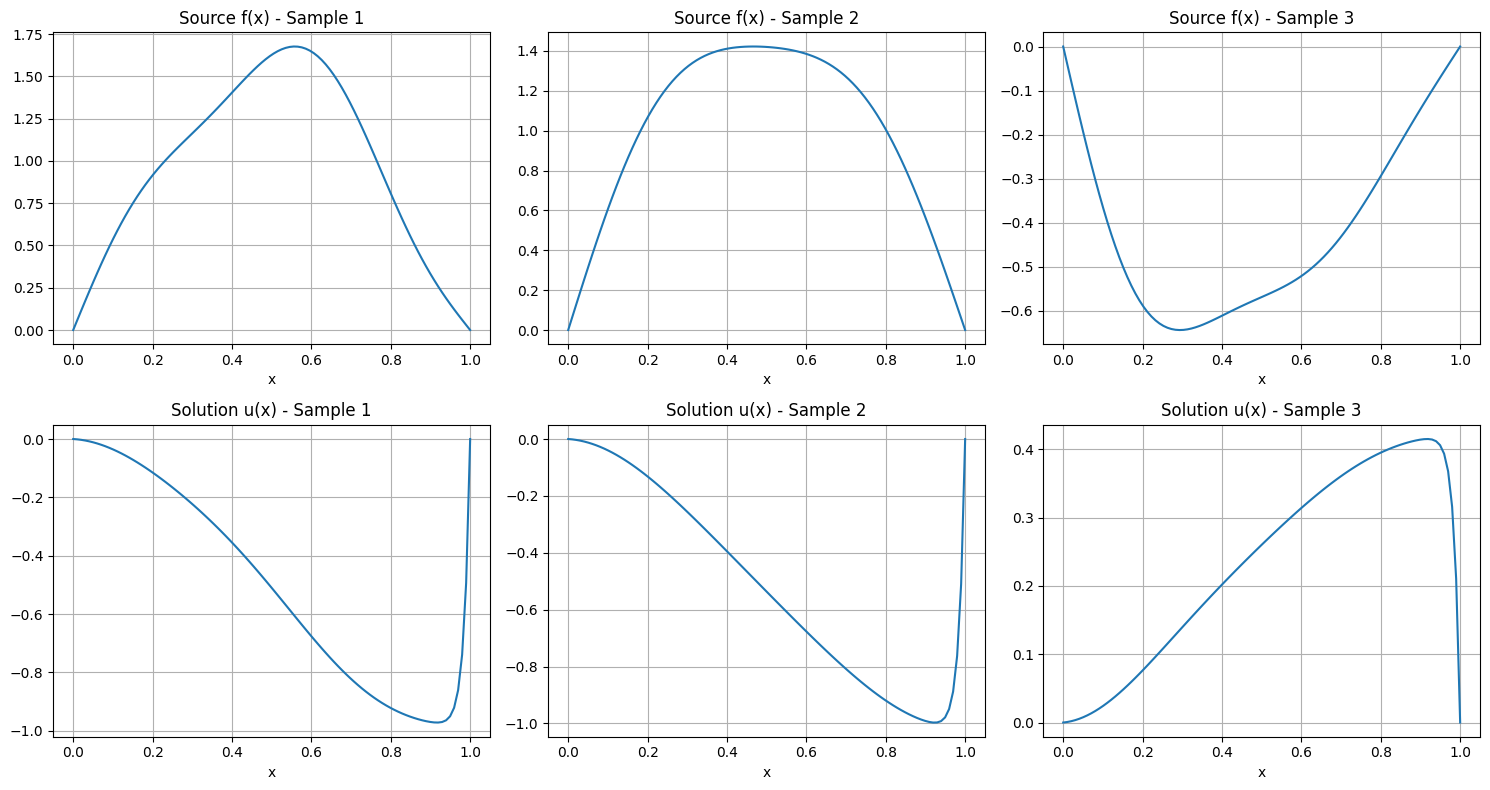

In [37]:
# Split into train and test sets (80-20 split)
indices = np.arange(N)
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)

f_train, f_test = f_data[train_idx], f_data[test_idx]
u_train, u_test = u_data[train_idx], u_data[test_idx]

print(f"Training samples: {len(train_idx)}")
print(f"Test samples: {len(test_idx)}")

# Convert to PyTorch tensors
f_train_tensor = torch.FloatTensor(f_train)
u_train_tensor = torch.FloatTensor(u_train)
f_test_tensor = torch.FloatTensor(f_test)
u_test_tensor = torch.FloatTensor(u_test)
x_tensor = torch.FloatTensor(x).reshape(1, -1)

# Visualize some samples
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for i in range(3):
    idx = np.random.choice(train_idx)
    axes[0, i].plot(x, f_data[idx])
    axes[0, i].set_title(f'Source f(x) - Sample {i+1}')
    axes[0, i].set_xlabel('x')
    axes[0, i].grid(True)
    
    axes[1, i].plot(x, u_data[idx])
    axes[1, i].set_title(f'Solution u(x) - Sample {i+1}')
    axes[1, i].set_xlabel('x')
    axes[1, i].grid(True)
plt.tight_layout()
plt.show()

In [24]:
class PIDeepONet(nn.Module):
    def __init__(self, branch_input_dim=102, trunk_input_dim=1, 
                 hidden_dim=64, num_hidden=3, output_dim=50,
                 nu=0.01, c=1.0):
        """
        Physics-Informed DeepONet
        
        Args:
            branch_input_dim: dimension of branch input [f(x1),...,f(xm), nu, c]
            trunk_input_dim: dimension of trunk input (spatial coordinate x)
            hidden_dim: number of neurons in hidden layers
            num_hidden: number of hidden layers
            output_dim: number of basis functions (p)
            nu: diffusion coefficient
            c: advection velocity
        """
        super(PIDeepONet, self).__init__()
        
        self.nu = nu
        self.c = c
        self.p = output_dim
        
        # Branch network: [f(x1),...,f(xm), nu, c] -> p coefficients
        branch_layers = []
        branch_layers.append(nn.Linear(branch_input_dim, hidden_dim))
        branch_layers.append(nn.Tanh())
        
        for _ in range(num_hidden - 1):
            branch_layers.append(nn.Linear(hidden_dim, hidden_dim))
            branch_layers.append(nn.Tanh())
        
        branch_layers.append(nn.Linear(hidden_dim, output_dim))
        self.branch = nn.Sequential(*branch_layers)
        
        # Trunk network: x -> p basis functions
        trunk_layers = []
        trunk_layers.append(nn.Linear(trunk_input_dim, hidden_dim))
        trunk_layers.append(nn.Tanh())
        
        for _ in range(num_hidden - 1):
            trunk_layers.append(nn.Linear(hidden_dim, hidden_dim))
            trunk_layers.append(nn.Tanh())
        
        trunk_layers.append(nn.Linear(hidden_dim, output_dim))
        self.trunk = nn.Sequential(*trunk_layers)
        
        # Bias term
        self.b0 = nn.Parameter(torch.zeros(1))
        
    def forward(self, f_values, x_coords):
        """
        Forward pass
        
        Args:
            f_values: (batch, nx) - function values
            x_coords: (batch, nx) - spatial coordinates
            
        Returns:
            u: (batch, nx) - predicted solution
        """
        batch_size = f_values.shape[0]
        nx = x_coords.shape[1]
        
        # Add parameters to branch input
        nu_vec = torch.full((batch_size, 1), self.nu, device=f_values.device)
        c_vec = torch.full((batch_size, 1), self.c, device=f_values.device)
        branch_input = torch.cat([f_values, nu_vec, c_vec], dim=1)
        
        # Branch output: (batch, p)
        branch_out = self.branch(branch_input)
        
        # Trunk output: (batch*nx, p)
        x_flat = x_coords.reshape(-1, 1)
        trunk_out = self.trunk(x_flat)  # (batch*nx, p)
        trunk_out = trunk_out.reshape(batch_size, nx, self.p)
        
        # Compute inner product: (batch, nx)
        u = torch.sum(branch_out.unsqueeze(1) * trunk_out, dim=2) + self.b0
        
        return u

# Create model
model = PIDeepONet(
    branch_input_dim=nx + 2,  # f values + nu + c
    trunk_input_dim=1,
    hidden_dim=64,
    num_hidden=3,
    output_dim=50,
    nu=nu,
    c=c
).to(device)

print("Model created successfully!")
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")
print("\nModel architecture:")
print(model)

Model created successfully!
Total parameters: 29861

Model architecture:
PIDeepONet(
  (branch): Sequential(
    (0): Linear(in_features=102, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=50, bias=True)
  )
  (trunk): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=50, bias=True)
  )
)


In [25]:
def compute_physics_loss(model, f_values, x_coords, u_pred):
    """
    Compute physics residual loss
    
    Args:
        model: PIDeepONet model
        f_values: (batch, nx) source function
        x_coords: (batch, nx) spatial coordinates (requires_grad=True)
        u_pred: (batch, nx) predicted solution
    
    Returns:
        loss_physics: physics residual loss
    """
    batch_size = f_values.shape[0]
    
    # Compute first derivative du/dx
    du_dx = torch.autograd.grad(
        outputs=u_pred,
        inputs=x_coords,
        grad_outputs=torch.ones_like(u_pred),
        create_graph=True,
        retain_graph=True
    )[0]
    
    # Compute second derivative d2u/dx2
    d2u_dx2 = torch.autograd.grad(
        outputs=du_dx,
        inputs=x_coords,
        grad_outputs=torch.ones_like(du_dx),
        create_graph=True,
        retain_graph=True
    )[0]
    
    # Physics residual: nu * d2u/dx2 - c * du/dx - f = 0
    residual = model.nu * d2u_dx2 - model.c * du_dx - f_values
    loss_physics = torch.mean(residual ** 2)
    
    return loss_physics

def compute_bc_loss(u_pred):
    """
    Compute boundary condition loss: u(0) = u(1) = 0
    
    Args:
        u_pred: (batch, nx) predicted solution
    
    Returns:
        loss_bc: boundary condition loss
    """
    u_left = u_pred[:, 0]
    u_right = u_pred[:, -1]
    loss_bc = torch.mean(u_left ** 2 + u_right ** 2)
    
    return loss_bc

def compute_total_loss(model, f_values, x_coords, u_true, 
                      lambda_physics=1.0, lambda_bc=10.0):
    """
    Compute total loss = data loss + physics loss + BC loss
    """
    # Forward pass
    u_pred = model(f_values, x_coords)
    
    # Data loss
    loss_data = torch.mean((u_pred - u_true) ** 2)
    
    # Physics loss (need to recompute with grad)
    x_coords_grad = x_coords.clone().detach().requires_grad_(True)
    u_pred_grad = model(f_values, x_coords_grad)
    loss_physics = compute_physics_loss(model, f_values, x_coords_grad, u_pred_grad)
    
    # BC loss
    loss_bc = compute_bc_loss(u_pred)
    
    # Total loss
    total_loss = loss_data + lambda_physics * loss_physics + lambda_bc * loss_bc
    
    return total_loss, loss_data, loss_physics, loss_bc

print("Loss functions defined!")

Loss functions defined!


In [26]:
# Training parameters
batch_size = 32
epochs = 1000
lambda_physics = 1.0
lambda_bc = 10.0
learning_rate = 1e-3
weight_decay = 1e-4

# Create DataLoader
train_dataset = TensorDataset(f_train_tensor, u_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=100, verbose=True
)

# Loss history
train_loss_history = []
data_loss_history = []
physics_loss_history = []
bc_loss_history = []

# Early stopping
best_loss = float('inf')
patience = 200
patience_counter = 0

print("Training setup complete!")
print(f"Batch size: {batch_size}")
print(f"Learning rate: {learning_rate}")
print(f"Weight decay: {weight_decay}")
print(f"λ_physics: {lambda_physics}, λ_BC: {lambda_bc}")

Training setup complete!
Batch size: 32
Learning rate: 0.001
Weight decay: 0.0001
λ_physics: 1.0, λ_BC: 10.0


/opt/anaconda3/envs/qian/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [27]:
print("Starting training...")
print("=" * 80)

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    epoch_data_loss = 0
    epoch_physics_loss = 0
    epoch_bc_loss = 0
    num_batches = 0
    
    for f_batch, u_batch in train_loader:
        # Move to device
        f_batch = f_batch.to(device)
        u_batch = u_batch.to(device)
        
        # Create spatial coordinate grid
        batch_size_curr = f_batch.shape[0]
        x_batch = x_tensor.repeat(batch_size_curr, 1).to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Compute loss
        total_loss, loss_data, loss_physics, loss_bc = compute_total_loss(
            model, f_batch, x_batch, u_batch,
            lambda_physics=lambda_physics,
            lambda_bc=lambda_bc
        )
        
        # Backward pass
        total_loss.backward()
        optimizer.step()
        
        # Accumulate losses
        epoch_loss += total_loss.item()
        epoch_data_loss += loss_data.item()
        epoch_physics_loss += loss_physics.item()
        epoch_bc_loss += loss_bc.item()
        num_batches += 1
    
    # Average losses
    avg_loss = epoch_loss / num_batches
    avg_data = epoch_data_loss / num_batches
    avg_physics = epoch_physics_loss / num_batches
    avg_bc = epoch_bc_loss / num_batches
    
    # Store history
    train_loss_history.append(avg_loss)
    data_loss_history.append(avg_data)
    physics_loss_history.append(avg_physics)
    bc_loss_history.append(avg_bc)
    
    # Learning rate scheduling
    scheduler.step(avg_loss)
    
    # Print progress
    if (epoch + 1) % 50 == 0 or epoch == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1:4d}/{epochs} | "
              f"Total: {avg_loss:.6f} | "
              f"Data: {avg_data:.6f} | "
              f"Physics: {avg_physics:.6f} | "
              f"BC: {avg_bc:.6f} | "
              f"LR: {current_lr:.6f}")
    
    # Early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            print(f"Best loss: {best_loss:.6f}")
            # Load best model
            model.load_state_dict(torch.load('best_model.pth'))
            break

print("\n" + "=" * 80)
print("Training completed!")
print(f"Final total loss: {train_loss_history[-1]:.6f}")
print(f"Best loss achieved: {best_loss:.6f}")

Starting training...
Epoch    1/1000 | Total: 0.592691 | Data: 0.120376 | Physics: 0.390639 | BC: 0.008168 | LR: 0.001000
Epoch   50/1000 | Total: 0.423549 | Data: 0.087461 | Physics: 0.270687 | BC: 0.006540 | LR: 0.001000
Epoch  100/1000 | Total: 0.411937 | Data: 0.086586 | Physics: 0.263242 | BC: 0.006211 | LR: 0.001000
Epoch  150/1000 | Total: 0.411665 | Data: 0.086859 | Physics: 0.263857 | BC: 0.006095 | LR: 0.001000
Epoch  200/1000 | Total: 0.412125 | Data: 0.087049 | Physics: 0.263054 | BC: 0.006202 | LR: 0.001000
Epoch  250/1000 | Total: 0.410921 | Data: 0.086567 | Physics: 0.262951 | BC: 0.006140 | LR: 0.001000
Epoch  300/1000 | Total: 0.410723 | Data: 0.086602 | Physics: 0.262791 | BC: 0.006133 | LR: 0.001000
Epoch  350/1000 | Total: 0.409992 | Data: 0.086531 | Physics: 0.262179 | BC: 0.006128 | LR: 0.001000
Epoch  400/1000 | Total: 0.409503 | Data: 0.086428 | Physics: 0.261761 | BC: 0.006131 | LR: 0.001000
Epoch  450/1000 | Total: 0.409643 | Data: 0.086349 | Physics: 0.261760

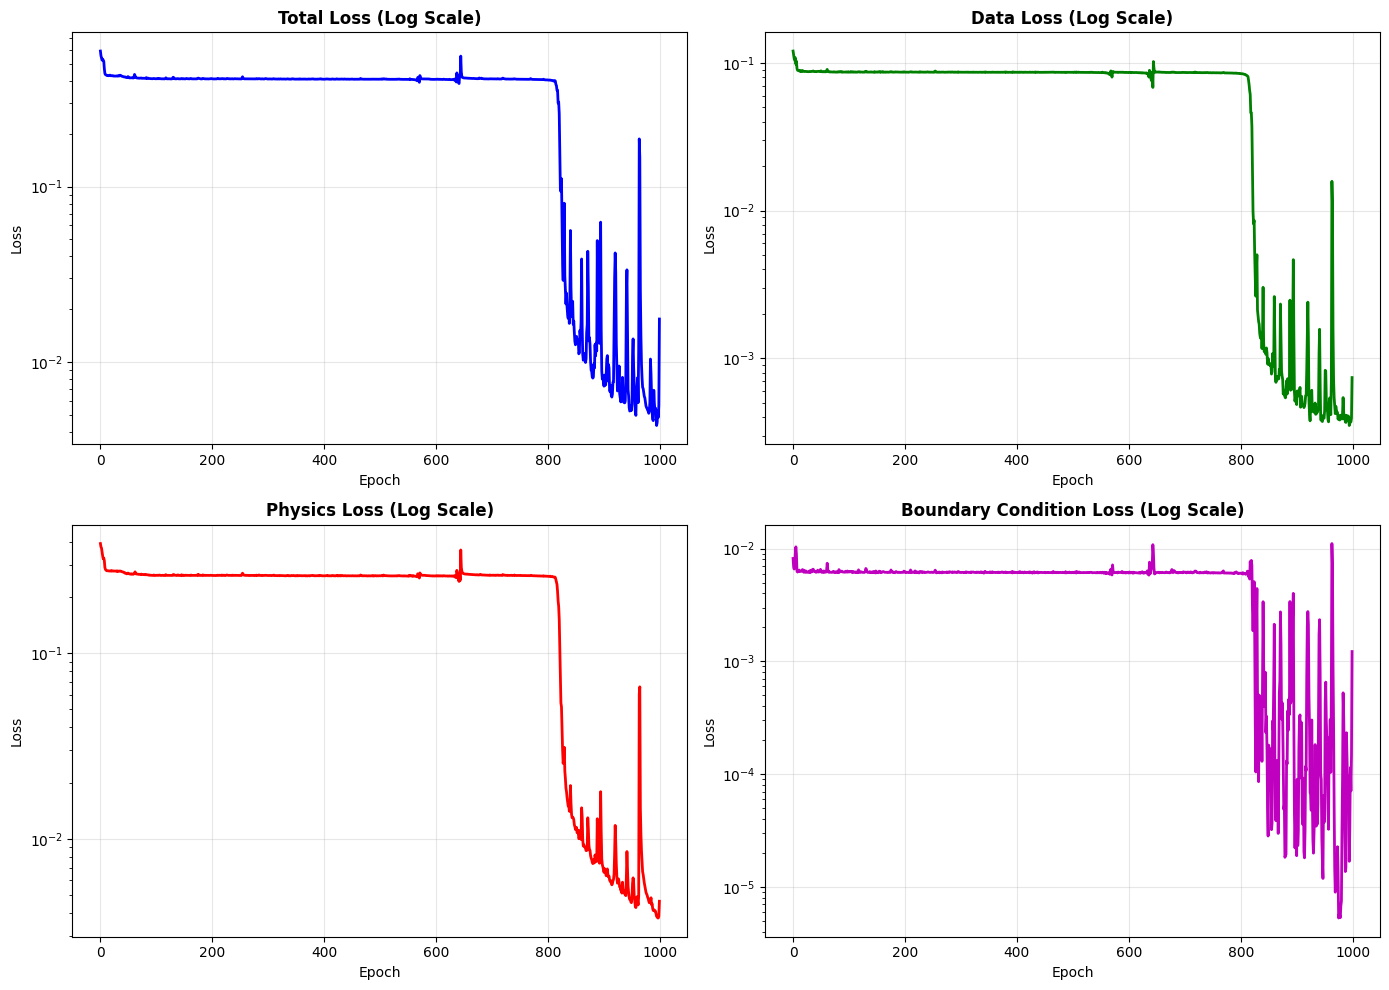

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Total loss
axes[0, 0].semilogy(train_loss_history, 'b-', linewidth=2)
axes[0, 0].set_title('Total Loss (Log Scale)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].grid(True, alpha=0.3)

# Data loss
axes[0, 1].semilogy(data_loss_history, 'g-', linewidth=2)
axes[0, 1].set_title('Data Loss (Log Scale)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].grid(True, alpha=0.3)

# Physics loss
axes[1, 0].semilogy(physics_loss_history, 'r-', linewidth=2)
axes[1, 0].set_title('Physics Loss (Log Scale)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].grid(True, alpha=0.3)

# BC loss
axes[1, 1].semilogy(bc_loss_history, 'm-', linewidth=2)
axes[1, 1].set_title('Boundary Condition Loss (Log Scale)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

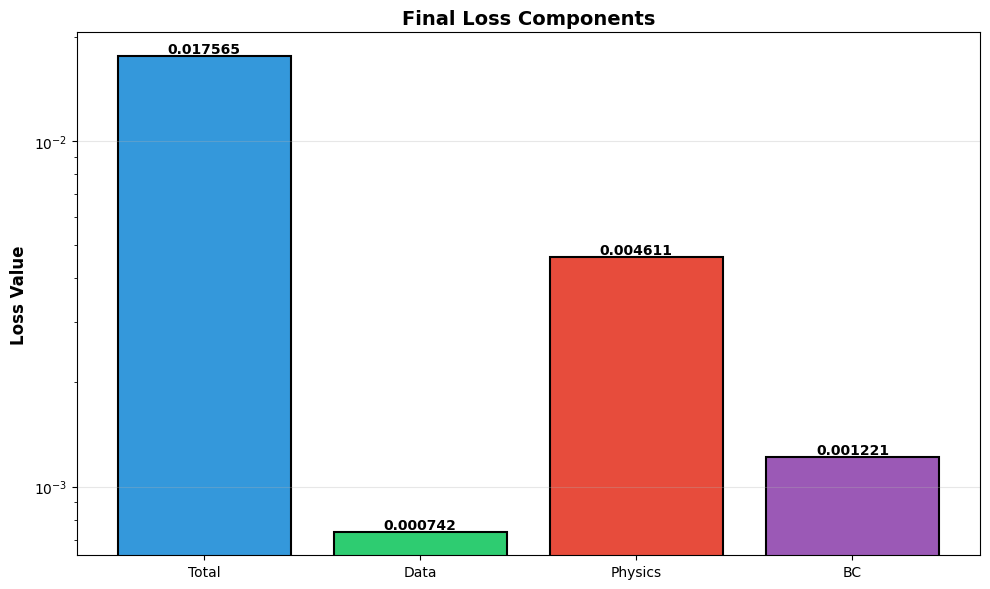


Final Loss Values:
Total     : 0.01756548
Data      : 0.00074165
Physics   : 0.00461084
BC        : 0.00122130


In [29]:
final_losses = {
    'Total': train_loss_history[-1],
    'Data': data_loss_history[-1],
    'Physics': physics_loss_history[-1],
    'BC': bc_loss_history[-1]
}

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(final_losses.keys(), final_losses.values(), 
              color=['#3498db', '#2ecc71', '#e74c3c', '#9b59b6'],
              edgecolor='black', linewidth=1.5)

ax.set_ylabel('Loss Value', fontsize=12, fontweight='bold')
ax.set_title('Final Loss Components', fontsize=14, fontweight='bold')
ax.set_yscale('log')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.6f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nFinal Loss Values:")
for name, value in final_losses.items():
    print(f"{name:10s}: {value:.8f}")

In [34]:
print("Evaluating on test set...")

model.eval()
with torch.no_grad():
    # Prepare test data
    f_test_device = f_test_tensor.to(device)
    u_test_device = u_test_tensor.to(device)
    x_test_batch = x_tensor.repeat(len(f_test), 1).to(device)
    
    # Predictions
    u_pred_test = model(f_test_device, x_test_batch).cpu().numpy()

u_test_np = u_test_tensor.numpy()

# 1. Average Relative L2 Error
l2_errors = []
for i in range(len(f_test)):
    u_true_i = u_test_np[i]
    u_pred_i = u_pred_test[i]
    l2_error = np.linalg.norm(u_true_i - u_pred_i) / (np.linalg.norm(u_true_i) + 1e-10)
    l2_errors.append(l2_error)

avg_l2_error = np.mean(l2_errors)
print(f"\nAverage Relative L² Error: {avg_l2_error:.6e}")

# 2. Average Physics Residual
physics_residuals = []
for i in range(len(f_test)):
    u_pred_i = u_pred_test[i]
    f_i = f_test[i]
    
    # Compute derivatives using finite differences
    du_dx = np.gradient(u_pred_i, x)
    d2u_dx2 = np.gradient(du_dx, x)
    
    # Physics residual: |nu * d2u/dx2 - c * du/dx - f|
    residual = np.abs(nu * d2u_dx2 - c * du_dx - f_i)
    avg_residual = np.mean(residual)
    physics_residuals.append(avg_residual)

avg_physics_residual = np.mean(physics_residuals)
print(f"Average Physics Residual: {avg_physics_residual:.6e}")
# print(f"   |ν·∂²u/∂x² - c·∂u/∂x - f|")

# 3. Average Boundary Error
boundary_errors = []
for i in range(len(f_test)):
    u_pred_i = u_pred_test[i]
    bc_error = np.abs(u_pred_i[0]) + np.abs(u_pred_i[-1])
    boundary_errors.append(bc_error)

avg_boundary_error = np.mean(boundary_errors)
print(f"Average Boundary Error: {avg_boundary_error:.6e}")
# print(f"   |u_pred(0)| + |u_pred(1)|")

# Create summary dictionary
test_metrics = {
    'Avg Relative L² Error': avg_l2_error,
    'Avg Physics Residual': avg_physics_residual,
    'Avg Boundary Error': avg_boundary_error
}

# Print summary table
print("\nTest Metrics Summary:")
print("-" * 40)
for metric, value in test_metrics.items():
    print(f"{metric:25s}: {value:.6e}")
print("-" * 40)

Evaluating on test set...

Average Relative L² Error: 1.456549e-01
Average Physics Residual: 3.446516e-01
Average Boundary Error: 2.123091e-02

Test Metrics Summary:
----------------------------------------
Avg Relative L² Error    : 1.456549e-01
Avg Physics Residual     : 3.446516e-01
Avg Boundary Error       : 2.123091e-02
----------------------------------------


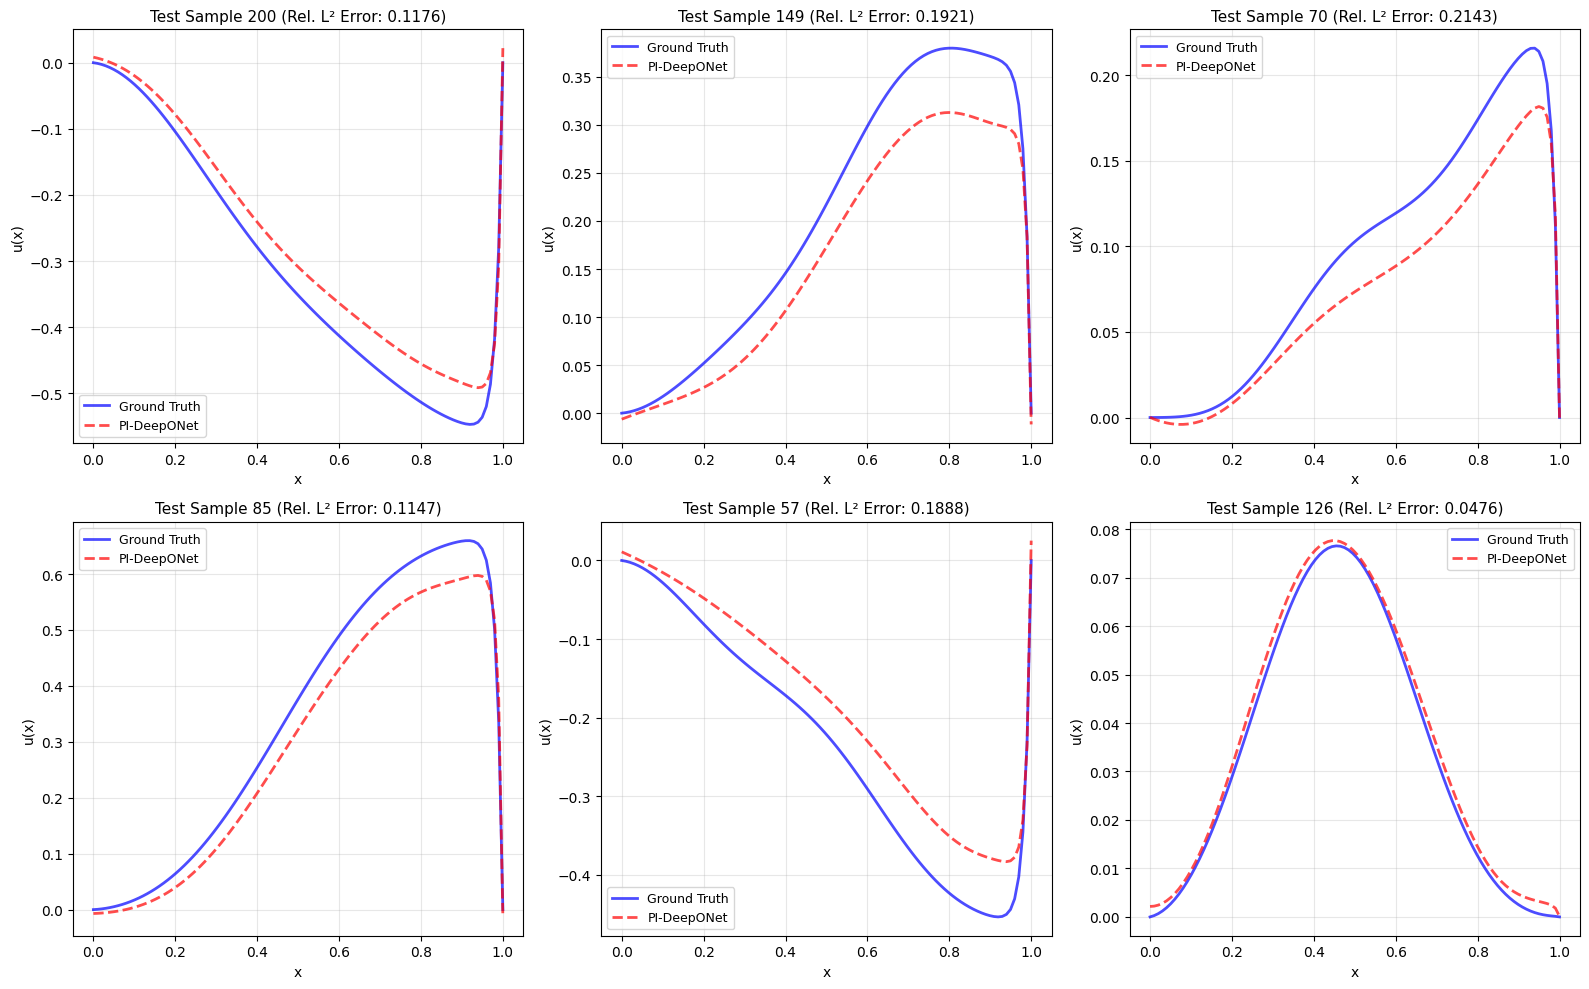

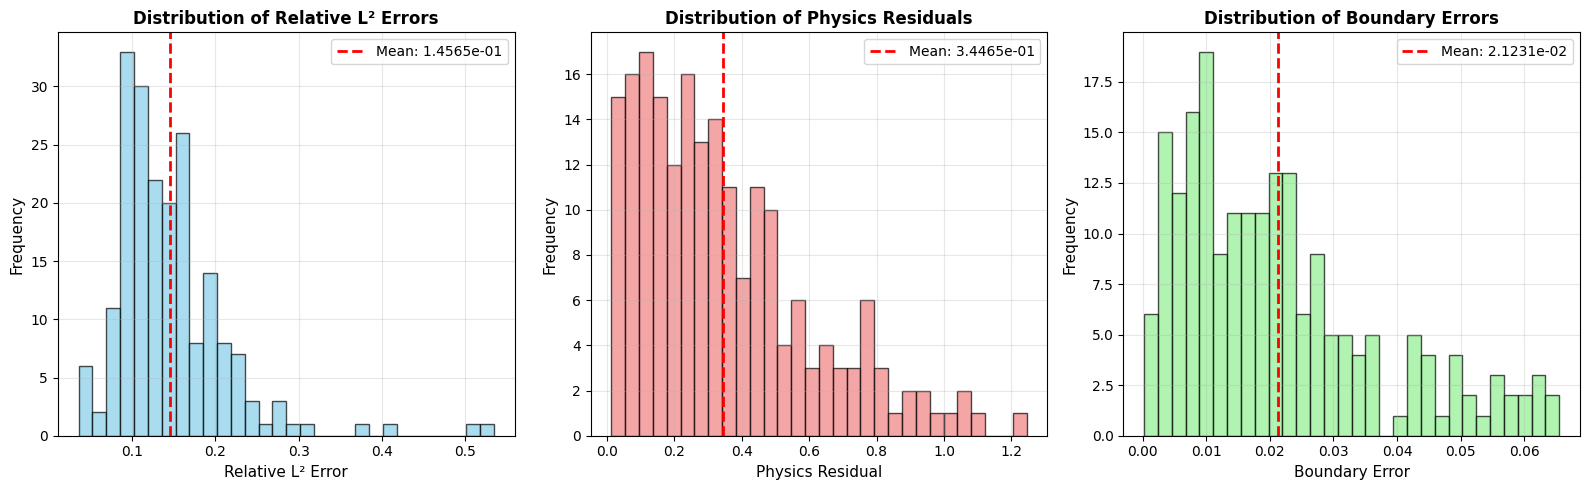

In [31]:
# Plot predictions vs ground truth for random test samples
num_samples = 6
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, ax in enumerate(axes):
    i = np.random.choice(len(f_test))
    
    ax.plot(x, u_test_np[i], 'b-', linewidth=2, label='Ground Truth', alpha=0.7)
    ax.plot(x, u_pred_test[i], 'r--', linewidth=2, label='PI-DeepONet', alpha=0.7)
    
    # Compute error for this sample
    error = l2_errors[i]
    
    ax.set_title(f'Test Sample {i+1} (Rel. L² Error: {error:.4f})', fontsize=11)
    ax.set_xlabel('x', fontsize=10)
    ax.set_ylabel('u(x)', fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot error distribution
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].hist(l2_errors, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].axvline(avg_l2_error, color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {avg_l2_error:.4e}')
axes[0].set_xlabel('Relative L² Error', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Distribution of Relative L² Errors', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(physics_residuals, bins=30, edgecolor='black', alpha=0.7, color='lightcoral')
axes[1].axvline(avg_physics_residual, color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {avg_physics_residual:.4e}')
axes[1].set_xlabel('Physics Residual', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Distribution of Physics Residuals', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].hist(boundary_errors, bins=30, edgecolor='black', alpha=0.7, color='lightgreen')
axes[2].axvline(avg_boundary_error, color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {avg_boundary_error:.4e}')
axes[2].set_xlabel('Boundary Error', fontsize=11)
axes[2].set_ylabel('Frequency', fontsize=11)
axes[2].set_title('Distribution of Boundary Errors', fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The higher error of PI-DeepONet stems from the added PDE and boundary constraints, which regularize the solution and reduce overfitting, while DeepONet has lower error at the expense of physical consistency.